Preprocessing the European Options data

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Load CSV
df_eu = pd.read_csv("/Users/judepereira/Downloads/OptionPrices_Europe.csv")

In [3]:
df_eu.head()

,SecurityID,OptionID,Exchange,Currency,Bid,UnderlyingBid,Ask,UnderlyingAsk,Last,UnderlyingLast,...,ContractSize,OptionStyle,Version,ExerciseStyle,Expiration,StartDate,VALOR,Issuer,SEDOL,ISIN
0,500096,151976957,21,814,-99.989998,71.669998,-99.989998,71.669998,43.680000,71.669998,...,100,0,0,A,2013-06-21,2013-01-02,11730015,adidas AG,4031976,DE000A1EWWW0
1,500096,151976957,21,814,-99.989998,78.269997,-99.989998,78.269997,50.279999,78.269997,...,100,0,0,A,2013-06-21,2013-01-02,11730015,adidas AG,4031976,DE000A1EWWW0
2,500096,151976957,21,814,-99.989998,70.540001,-99.989998,70.540001,42.549999,70.540001,...,100,0,0,A,2013-06-21,2013-01-02,11730015,adidas AG,4031976,DE000A1EWWW0
3,500096,151976957,21,814,-99.989998,78.900002,-99.989998,78.900002,50.910000,78.900002,...,100,0,0,A,2013-06-21,2013-01-02,11730015,adidas AG,4031976,DE000A1EWWW0
4,500096,151976957,21,814,-99.989998,76.199997,-99.989998,76.199997,48.209999,76.199997,...,100,0,0,A,2013-06-21,2013-01-02,11730015,adidas AG,4031976,DE000A1EWWW0


In [4]:
# Convert to datetime
df_eu['Date'] = pd.to_datetime(df_eu['Date'], errors='coerce')
df_eu['Expiration'] = pd.to_datetime(df_eu['Expiration'], errors='coerce')
df_eu = df_eu.dropna(subset=['Date', 'Expiration'])

In [5]:
# Time to maturity (in years)
df_eu['tau'] = (df_eu['Expiration'] - df_eu['Date']).dt.days / 365.0
df_eu = df_eu[df_eu['tau'] > 0]

In [6]:
# Moneyness
df_eu['moneyness'] = df_eu['UnderlyingLast'] / df_eu['Strike']

In [7]:
# Target: mid price
df_eu['mid_price'] = (df_eu['Bid'] + df_eu['Ask']) / 2

In [8]:
# Final dataset
features_eu = df_eu[['moneyness', 'tau', 'ImpliedVolatility']]
target_eu = df_eu['mid_price']

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

/Users/judepereira/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [10]:
# Prepare data
X = features_eu.values
y = target_eu.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
model = Sequential([
    Input(shape=(3,)),
    Dense(400),
    LeakyReLU(negative_slope=0.01),
    BatchNormalization(),
    Dense(400),
    LeakyReLU(negative_slope=0.01),
    BatchNormalization(),
    Dense(1, activation='linear')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [15]:
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=128,
                    validation_split=0.2, callbacks=[early_stop], verbose=1)

Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9936.4990 - val_loss: 9598.4521
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9457.6787 - val_loss: 8620.3779
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8405.6846 - val_loss: 7069.4678
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6825.6636 - val_loss: 5182.1328
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4979.2305 - val_loss: 3354.3079
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3196.5417 - val_loss: 1858.7649
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1761.1190 - val_loss: 840.2997
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 809.0893 - val_loss: 298.8900
Epoch 9/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 302.9786 - val_loss: 81.7116
Epoch 10/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 93.8575 - val_loss: 13.3428
Epoch 11/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.5037 - val_loss: 1.9614
Epoch 12/100

In [16]:
# Evaluate
loss = model.evaluate(X_test_scaled, y_test)
print(f'Test MSE: {loss:.4f}')

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - loss: 0.0519
Test MSE: 0.0620


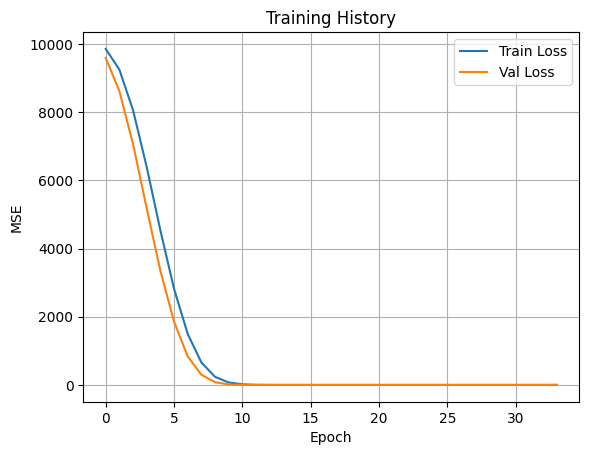

In [17]:
# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

Preprocessing the US Options data

In [18]:
# Load CSV
df_us = pd.read_csv("/Users/judepereira/Downloads/OptionPricesUS.csv")
df_us_sec = pd.read_csv("/Users/judepereira/Downloads/SecurityPricesUS.csv")

In [19]:
# Filter and clean
df_us = df_us.dropna(subset=['impl_volatility', 'best_bid', 'best_offer', 'date', 'exdate'])
df_us['date'] = pd.to_datetime(df_us['date'], errors='coerce')
df_us['exdate'] = pd.to_datetime(df_us['exdate'], errors='coerce')
df_us = df_us.dropna(subset=['date', 'exdate'])

In [20]:
# Time to maturity
df_us['tau'] = (df_us['exdate'] - df_us['date']).dt.days / 365.0
df_us = df_us[df_us['tau'] > 0]

In [21]:
# Strike in dollars
df_us['strike_price'] = df_us['strike_price'] / 100.0

In [22]:
# Compute mid prices
df_us['mid_price'] = (df_us['best_bid'] + df_us['best_offer']) / 2

In [23]:
# Preprocess US Security prices data
df_us_sec['date'] = pd.to_datetime(df_us_sec['date'], errors='coerce')

In [24]:
# Merge close price from security prices into US options
df_us = df_us.merge(df_us_sec[['secid', 'date', 'close']], on=['secid', 'date'], how='left')
df_us = df_us.rename(columns={'close': 'underlying_price'})

In [25]:
# Compute moneyness using underlying
df_us['moneyness'] = df_us['underlying_price'] / df_us['strike_price']

In [26]:
# Final dataset
features_us = df_us[['moneyness', 'tau', 'impl_volatility']]
target_us = df_us['mid_price']

In [27]:
X = features_us.values
y = target_us.values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
# Define model
model = Sequential([
    Input(shape=(3,)),
    Dense(400),
    LeakyReLU(negative_slope=0.01),
    BatchNormalization(),
    Dense(400),
    LeakyReLU(negative_slope=0.01),
    BatchNormalization(),
    Dense(400),
    LeakyReLU(negative_slope=0.01),
    BatchNormalization(),
    Dense(1, activation='relu')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
history = model.fit(X_train_scaled, y_train, epochs=1000, batch_size=128, validation_split=0.2, verbose=1)

Epoch 1/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9172.3877 - val_loss: 9287.7607
Epoch 2/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6611.5156 - val_loss: 8068.8403
Epoch 3/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5704.2402 - val_loss: 7720.5903
Epoch 4/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4952.0303 - val_loss: 6156.9189
Epoch 5/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4209.2290 - val_loss: 5391.5513
Epoch 6/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4125.0078 - val_loss: 5076.5142
Epoch 7/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3746.7207 - val_loss: 4876.6274
Epoch 8/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3597.7839 - val_loss: 3447.3542
Epoch 9/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3638.0098 - val_loss: 3095.1831
Epoch 10/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3271.1155 - val_loss: 2981.2727
Epoch 11/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - loss: 2045.8169
Test MSE: 2053.0278


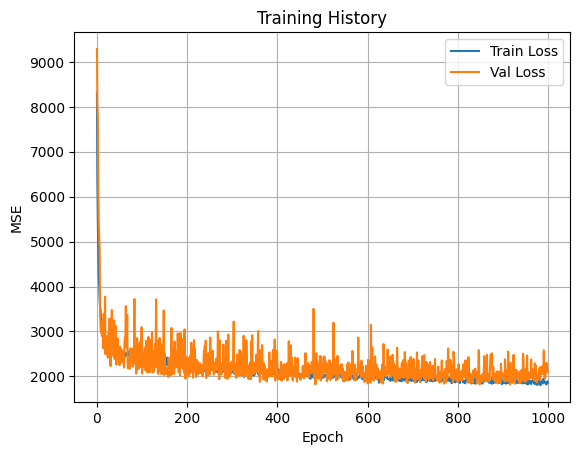

In [33]:
# Evaluate and plot
loss = model.evaluate(X_test_scaled, y_test)
print(f"Test MSE: {loss:.4f}")

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training History")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()

Compute Black-Scholes Prices for Comparison

In [36]:
from scipy.stats import norm

def black_scholes_call(S, K, T, r, sigma):
    """European call option price via Black-Scholes formula."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

Apply to European options

In [34]:
S_eu = df_eu['UnderlyingLast'].values
K_eu = df_eu['Strike'].values
T_eu = df_eu['tau'].values
sigma_eu = df_eu['ImpliedVolatility'].values
r_eu = 0.01  # Assumed risk-free rate

In [37]:
# Filter valid rows
valid_mask = (S_eu > 0) & (K_eu > 0) & (T_eu > 0) & (sigma_eu > 0)

# Initialize price array with NaNs
bs_price_eu = np.full_like(S_eu, fill_value=np.nan, dtype=np.float64)

# Compute BS price only for valid rows
bs_price_eu[valid_mask] = black_scholes_call(
    S_eu[valid_mask], K_eu[valid_mask], T_eu[valid_mask], r_eu, sigma_eu[valid_mask]
)

# Assign to DataFrame
df_eu['bs_price'] = bs_price_eu

In [38]:
print(f"Filtered out {np.sum(~valid_mask)} rows with invalid inputs.")

Filtered out 5299 rows with invalid inputs.


Apply to US Options

In [39]:
S_us = df_us['underlying_price'].values
K_us = df_us['strike_price'].values
T_us = df_us['tau'].values
sigma_us = df_us['impl_volatility'].values
r_us = 0.01  # Assumed risk-free rate

bs_price_us = black_scholes_call(S_us, K_us, T_us, r_us, sigma_us)
df_us['bs_price'] = bs_price_us

In [40]:
from sklearn.metrics import mean_squared_error

# Drop NaNs from European data
df_eu_valid = df_eu.dropna(subset=['mid_price', 'bs_price'])
mse_eu = mean_squared_error(df_eu_valid['mid_price'], df_eu_valid['bs_price'])

mse_us = mean_squared_error(df_us['mid_price'], df_us['bs_price'])

print(f"European BS MSE: {mse_eu:.4f}")
print(f"US BS MSE: {mse_us:.4f}")


European BS MSE: 9997.9997
US BS MSE: 11458.1564
